<a href="https://colab.research.google.com/github/mp22abw/Final-Project/blob/main/walmart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Walmart.csv')
df.head()

Mounted at /content/drive


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


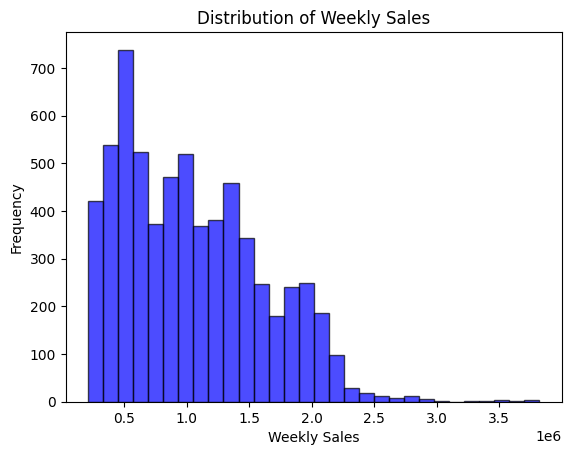

In [4]:
df['Weekly_Sales'].plot(kind='hist', bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Weekly Sales')
plt.show()


In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Check for missing values and duplicates
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()

print("Missing values per column:")
print(missing_values)
print("\nNumber of duplicate rows:")
print(duplicates)

Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Number of duplicate rows:
0


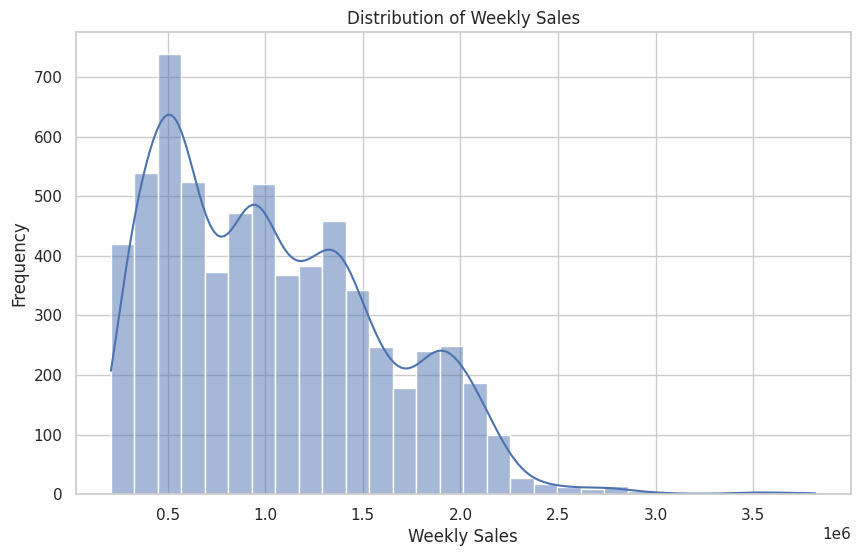

In [6]:
import seaborn as sns
# Set the style of the visualizations
sns.set_theme(style="whitegrid")

# Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=30, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

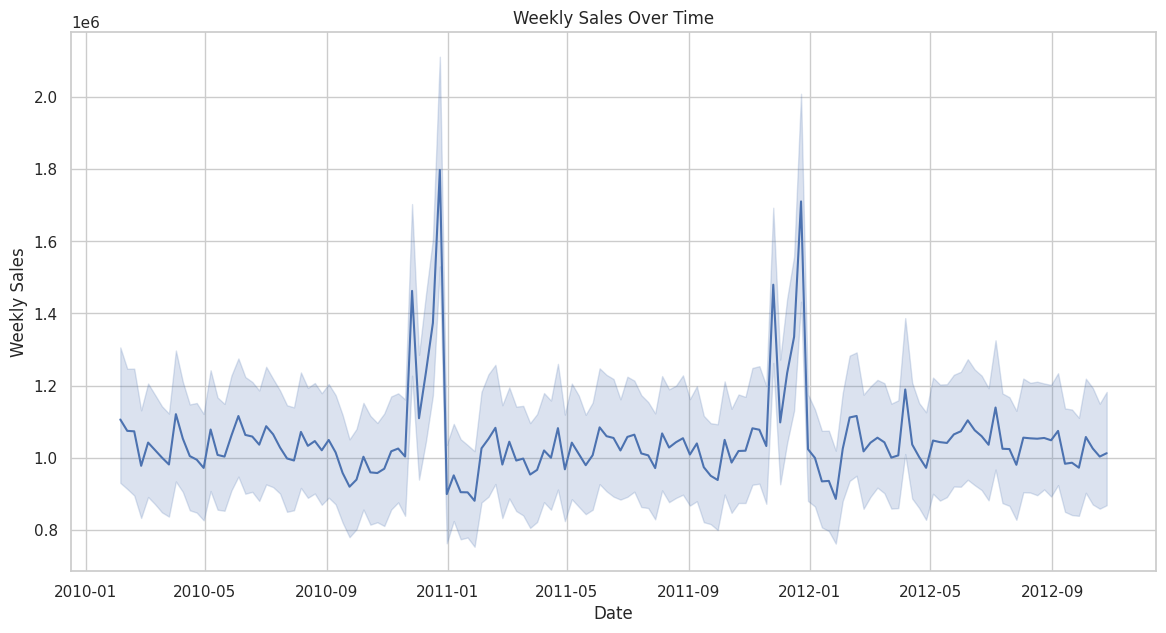

In [7]:
# Sales Trends Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

<Figure size 1600x800 with 0 Axes>

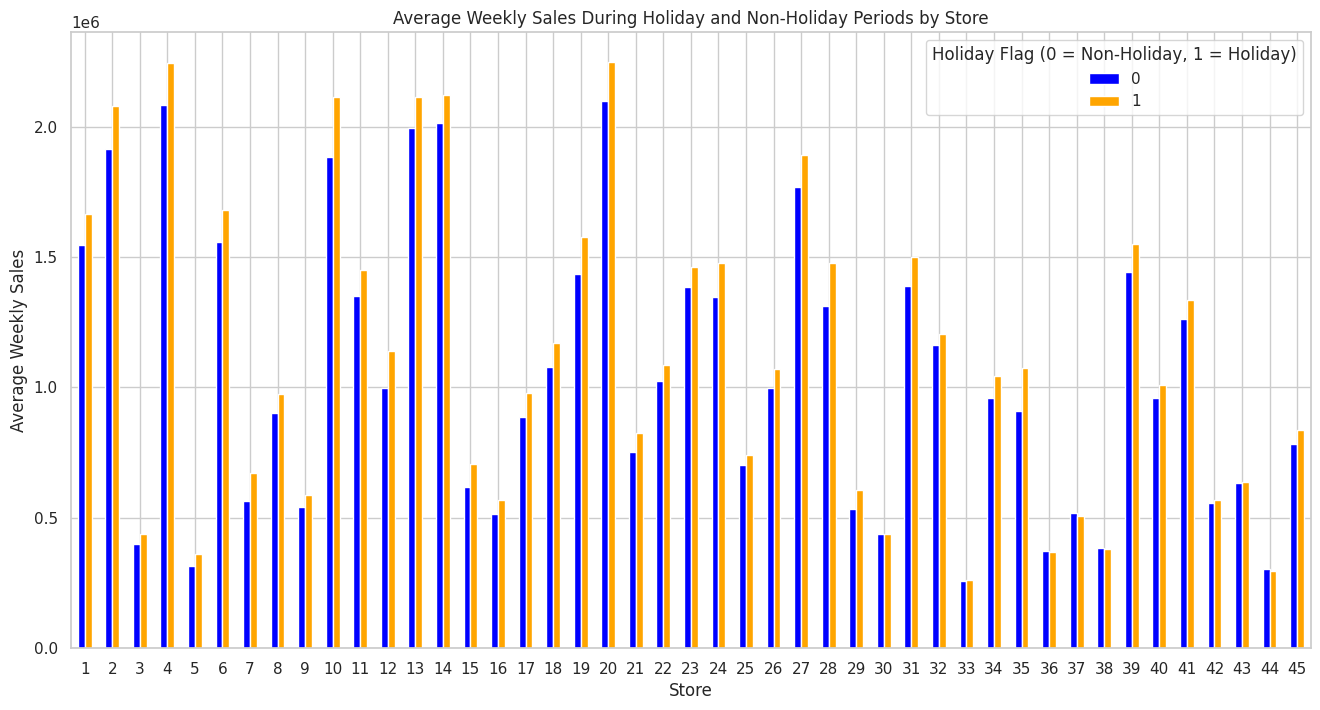

In [8]:

# Group by 'Store' and 'Holiday_Flag' and calculate the mean of 'Weekly_Sales'
sales_by_store_holiday = df.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales'].mean().unstack()

# Plot the bar graph
plt.figure(figsize=(16, 8))
sales_by_store_holiday.plot(kind='bar', stacked=False, figsize=(16, 8), color=['blue', 'orange'])

# Adding title and labels
plt.title('Average Weekly Sales During Holiday and Non-Holiday Periods by Store')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Holiday Flag (0 = Non-Holiday, 1 = Holiday)')

# Show the plot
plt.show()

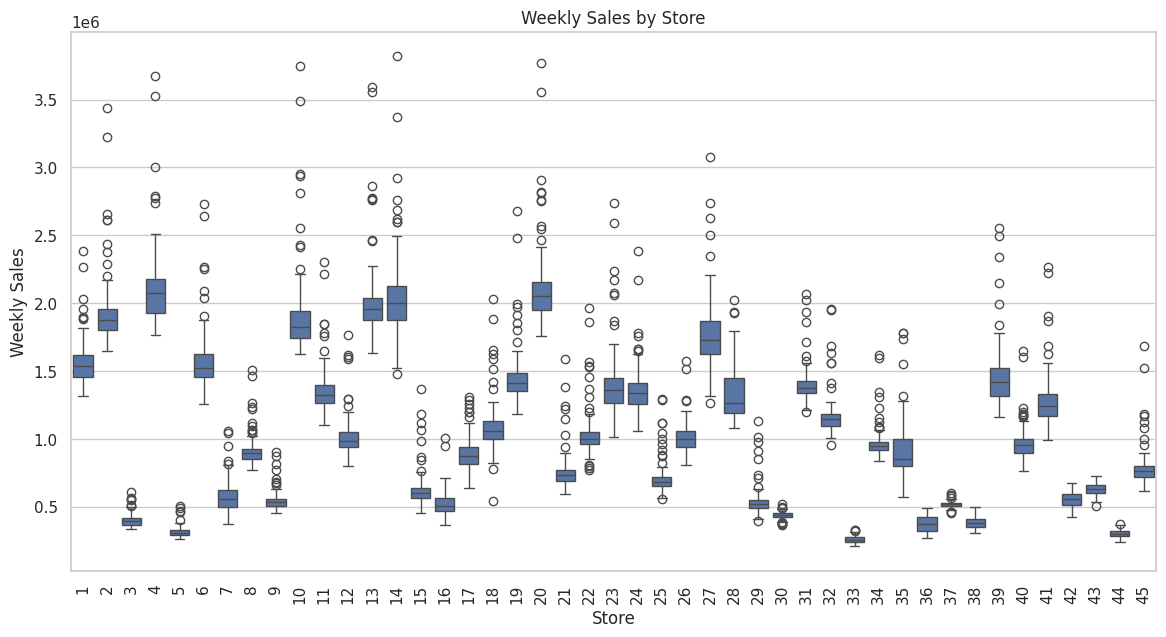

In [9]:
# Sales by Store
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Store', y='Weekly_Sales')
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.show()

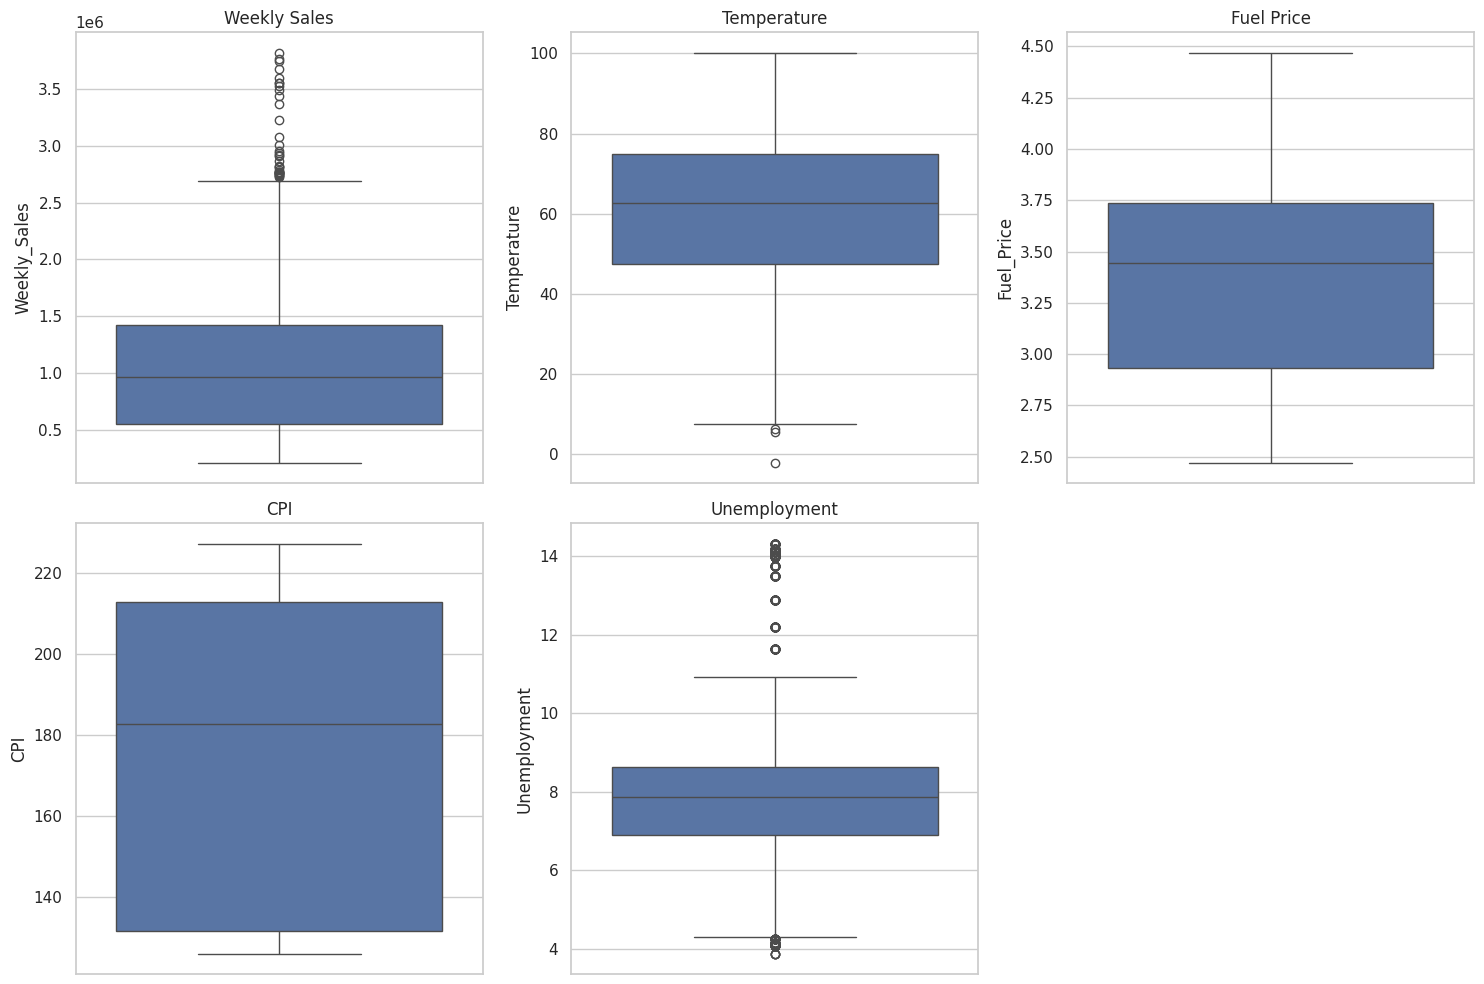

In [10]:
plt.figure(figsize=(15, 10))  # Increase the figure size
plt.subplot(2, 3, 1)
sns.boxplot(y=df['Weekly_Sales'])
plt.title('Weekly Sales')

plt.subplot(2, 3, 2)
sns.boxplot(y=df['Temperature'])
plt.title('Temperature')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['Fuel_Price'])
plt.title('Fuel Price')

plt.subplot(2, 3, 4)
sns.boxplot(y=df['CPI'])
plt.title('CPI')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['Unemployment'])
plt.title('Unemployment')

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Function to calculate outliers using IQR method
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Calculate outliers for each relevant column
weekly_sales_outliers = calculate_outliers(df['Weekly_Sales'])
temperature_outliers = calculate_outliers(df['Temperature'])
fuel_price_outliers = calculate_outliers(df['Fuel_Price'])
cpi_outliers = calculate_outliers(df['CPI'])
unemployment_outliers = calculate_outliers(df['Unemployment'])

# Summary of outliers
outliers_summary = {
    'Weekly_Sales_Outliers': weekly_sales_outliers,
    'Temperature_Outliers': temperature_outliers,
    'Fuel_Price_Outliers': fuel_price_outliers,
    'CPI_Outliers': cpi_outliers,
    'Unemployment_Outliers': unemployment_outliers
}

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Set the date as the index
df.set_index('Date', inplace=True)

# Resampling the data by week
weekly_data = df['Weekly_Sales'].resample('W').sum()

# Function to create training and test datasets
def create_train_test_split(data, train_size=0.8):
    train_len = int(len(data) * train_size)
    train_data = data[:train_len]
    test_data = data[train_len:]
    return train_data, test_data

# Train-test split
train_data, test_data = create_train_test_split(weekly_data)

# Preprocessing for LSTM
def preprocess_lstm(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(weekly_data.values.reshape(-1, 1))

# Prepare the data for LSTM
time_step = 4
X_train, y_train = preprocess_lstm(scaled_data[:len(train_data)], time_step)
X_test, y_test = preprocess_lstm(scaled_data[len(train_data):], time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3042
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2448
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9004
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9209
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7938
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM Train Score: 46840138.59 RMSE
LSTM Test Score: 46959977.22 RMSE
ARIMA Test Score: 3924134.11 RMSE


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprti4xkdo/h3xsajsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprti4xkdo/c5ki6o8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7830', 'data', 'file=/tmp/tmprti4xkdo/h3xsajsh.json', 'init=/tmp/tmprti4xkdo/c5ki6o8g.json', 'output', 'file=/tmp/tmprti4xkdo/prophet_modelzb84zf9o/prophet_model-20240817140056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


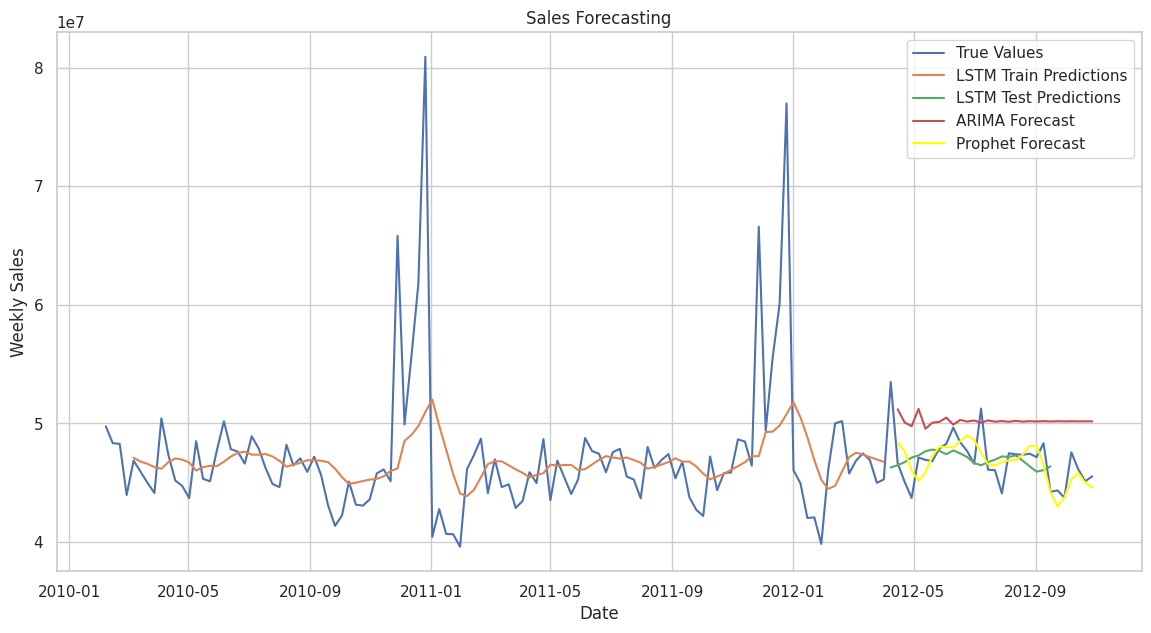

In [12]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=5)

# Predicting
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test, test_predict[:,0]))

print(f'LSTM Train Score: {train_score:.2f} RMSE')
print(f'LSTM Test Score: {test_score:.2f} RMSE')

# Forecasting with ARIMA
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f'ARIMA Test Score: {arima_rmse:.2f} RMSE')
# Forecasting with Prophet
prophet_df = weekly_data.reset_index().rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df.iloc[:len(train_data)])
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
prophet_forecast = prophet_model.predict(future)

# Determine the length of test predictions and corresponding x values
len_test_predict = len(test_predict)
len_test_index = len(weekly_data.index[len(train_predict) + time_step:])

# Adjust the index if necessary
if len_test_index > len_test_predict:
    x_values = weekly_data.index[len(train_predict) + time_step:len(train_predict) + time_step + len_test_predict]
else:
    x_values = weekly_data.index[len(train_predict) + time_step:]

# Plotting the results
plt.figure(figsize=(14, 7))

# LSTM Predictions
plt.plot(weekly_data.index, weekly_data.values, label='True Values')
plt.plot(weekly_data.index[time_step:len(train_predict) + time_step], train_predict, label='LSTM Train Predictions')
plt.plot(x_values, test_predict, label='LSTM Test Predictions')

# ARIMA Predictions
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')

# Prophet Predictions
plt.plot(test_data.index, prophet_forecast['yhat'].iloc[-len(test_data):], label='Prophet Forecast', color='yellow')

plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [13]:
# RMSE for LSTM
train_score = np.sqrt(mean_squared_error(y_train, train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test, test_predict[:,0]))

print(f'LSTM Train Score: {train_score:.2f} RMSE')
print(f'LSTM Test Score: {test_score:.2f} RMSE')

LSTM Train Score: 46840138.59 RMSE
LSTM Test Score: 46959977.22 RMSE


In [14]:
# RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f'ARIMA Test Score: {arima_rmse:.2f} RMSE')

ARIMA Test Score: 3924134.11 RMSE


In [15]:
# RMSE for Prophet
prophet_rmse = np.sqrt(mean_squared_error(test_data, prophet_forecast['yhat'].iloc[-len(test_data):]))
print(f'Prophet Test Score: {prophet_rmse:.2f} RMSE')

Prophet Test Score: 1477382.36 RMSE


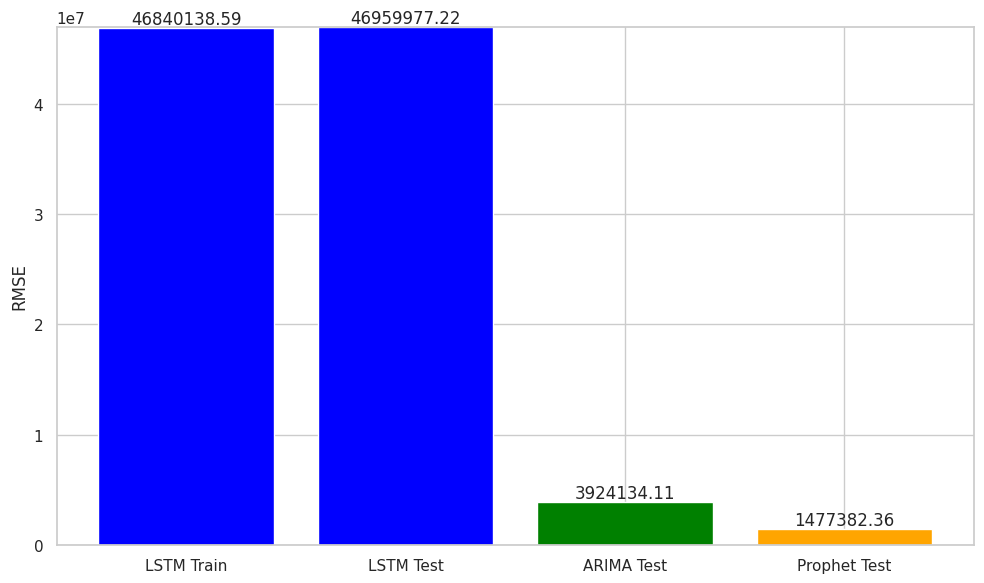

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the x-axis
labels = ['LSTM Train', 'LSTM Test', 'ARIMA Test', 'Prophet Test']

# RMSE values
rmse_values = [train_score, test_score, arima_rmse, prophet_rmse]

# Plotting the RMSE comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, rmse_values, color=['blue', 'blue', 'green', 'orange'])

# Adding the RMSE values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# plt.title('Comparison of RMSE for LSTM, ARIMA, and Prophet Models',loc='top')

plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 500)
plt.tight_layout()
plt.show()


In [17]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324


In [38]:

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Reset index to get 'Date' as a column
df.reset_index(inplace=True)

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Set the date as the index
df.set_index('Date', inplace=True)

# Resampling the data by week
weekly_data = df['Weekly_Sales'].resample('W').sum()

# Reset index for Prophet
prophet_df = df.resample('W').sum().reset_index().rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

# Adding additional regressors and handling NaN values
prophet_df['Temperature'] = df['Temperature'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
prophet_df['Fuel_Price'] = df['Fuel_Price'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
prophet_df['Holiday_Flag'] = df['Holiday_Flag'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
prophet_df['CPI'] = df['CPI'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
prophet_df['Unemployment'] = df['Unemployment'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')

# Create Prophet model
prophet_model = Prophet()

# Add the additional regressors
prophet_model.add_regressor('Temperature')
prophet_model.add_regressor('Fuel_Price')
prophet_model.add_regressor('Holiday_Flag')
prophet_model.add_regressor('CPI')
prophet_model.add_regressor('Unemployment')

# Fit the model
prophet_model.fit(prophet_df)


future = prophet_model.make_future_dataframe(periods=len(weekly_data), freq='W')


# Add the same additional regressors to the future dataframe and handle NaN values
future['Temperature'] = df['Temperature'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')[:len(future)]
future['Fuel_Price'] = df['Fuel_Price'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')[:len(future)]
future['Holiday_Flag'] = df['Holiday_Flag'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')[:len(future)]
future['CPI'] = df['CPI'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')[:len(future)]
future['Unemployment'] = df['Unemployment'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')[:len(future)]

<ipython-input-38-2e51a69b6056>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['Temperature'] = df['Temperature'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
<ipython-input-38-2e51a69b6056>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['Fuel_Price'] = df['Fuel_Price'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
<ipython-input-38-2e51a69b6056>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['Holiday_Flag'] = df['Holiday_Flag'].resample('W').mean().reset_index(drop=True).fillna(method='ffill')
<ipython-input-38-2e51a69b6056>:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or 

In [39]:
# Drop rows with any NaN values to avoid errors
future.dropna(inplace=True)

In [40]:
# Forecast
forecast = prophet_model.predict(future)

# Calculate RMSE for the forecasted period
prophet_rmse = np.sqrt(mean_squared_error(weekly_data[-len(forecast):], forecast['yhat'].iloc[-len(weekly_data):]))
print(f'Prophet Test Score with Regressors: {prophet_rmse:.2f} RMSE')



Prophet Test Score with Regressors: 3411600.87 RMSE


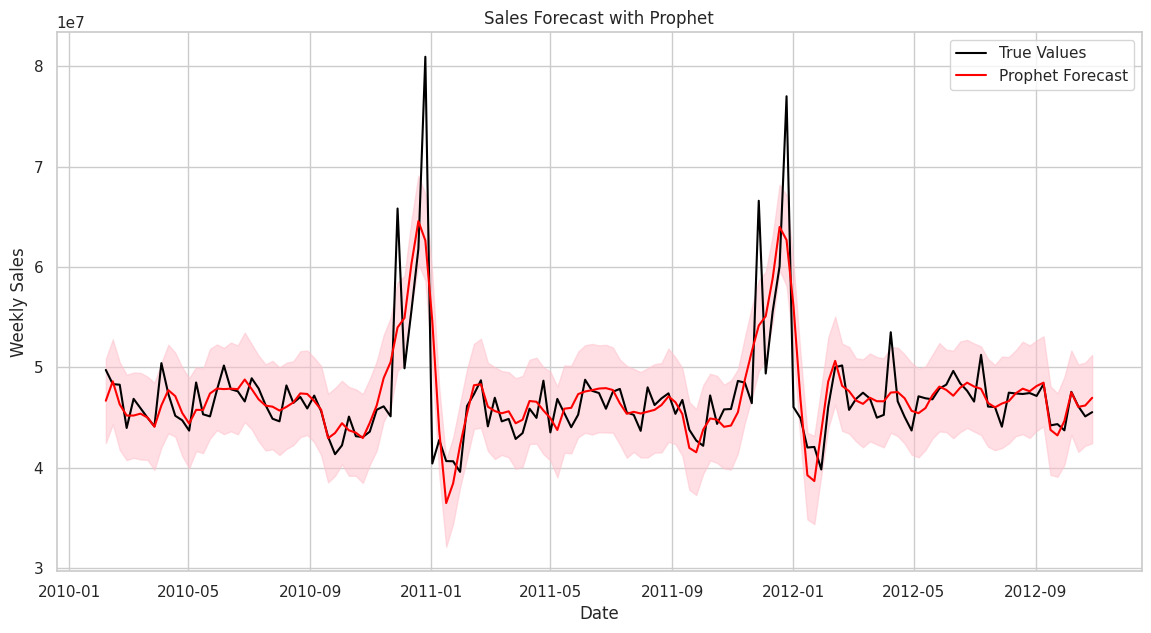

In [41]:
# Plotting the forecast against the actual sales
plt.figure(figsize=(14, 7))
plt.plot(weekly_data.index, weekly_data.values, label='True Values', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()